# ECG Classifier
This application takes a 12 lead ECG as input and predicts whether it is normal or abnormal. 

In [444]:
#Imports and setup code
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#Rescales values in a 12-lead ECG to a range of -1 to 1
def normalize(signal):
    maximum = max(signal[9])
    for i in range(12):
        for j in range(len(signal[0])):
            signal[i][j] /= maximum
            
    return signal[:, :4096]

#Transforms a signal from its stored format to the format required for the model
def transform_for_input(signal):
    signal = normalize(signal)
    signal = np.swapaxes(signal, 0, 1)
    
    return np.array([signal])


## Make Predictions

In [446]:
ecg_path = f'../data/records/A00004.h5' #Modify this value to select the desired ECG
model_path = '../logs/backup_model_best.keras'

with h5py.File(ecg_path, 'r') as f:
    signal = f['ecg'][:, :4096]
    
signal = transform_for_input(signal)

model = tf.keras.models.load_model(model_path)
model.predict(signal)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


array([[0.82276803]], dtype=float32)

## Training Data

The file 'metadata.csv' contains information about the patient and diagnoses associated with each ECG. Each code represents a different diagnostic statement; a code of 1 signifies a normal ECG.

In [384]:
metadata_df = pd.read_csv("../data/metadata.csv")
metadata_df.head(10)

,ECG_ID,AHA_Code,Patient_ID,Age,Sex,N,Date
0,A00001,22;23,S00001,55,M,5000,2020-03-04
1,A00002,1,S00002,32,M,6000,2019-09-03
2,A00003,1,S00003,63,M,6500,2020-07-16
3,A00004,23,S00004,31,M,5000,2020-07-14
4,A00005,146,S00005,47,M,5500,2020-01-07
5,A00006,1,S00006,46,F,5000,2019-08-31
6,A00007,106,S00007,75,M,6500,2020-04-01
7,A00008,1,S00008,32,M,5000,2019-10-02
8,A00009,1,S00009,48,F,6000,2019-08-20
9,A00010,1,S00010,32,F,7500,2020-06-29


First, let's take a look at the distribution of classes within the dataset. It is quite balanced, with slightly more normal than abnormal ECGs. The group of abnormal ECGs is comprised of a wide variety of different diagnoses. The code below displays the counts of normal vs abnormal records.

In [457]:
normal_cnt = len(metadata_df[metadata_df.AHA_Code == '1'])
abnormal_cnt = len(metadata_df) - normal_cnt
normal_pct = (normal_cnt / len(metadata_df)) * 100
abnormal_pct = (abnormal_cnt / len(metadata_df)) * 100
print(f'The dataset contains {normal_cnt} normal ECGs and {abnormal_cnt} abnormal ECGs.')

The dataset contains 13905 normal ECGs and 11865 abnormal ECGs.


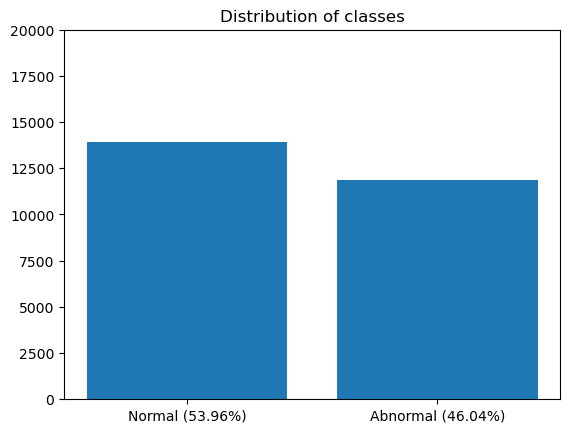

In [459]:
plt.bar([f'Normal ({normal_pct:.2f}%)', f'Abnormal ({abnormal_pct:.2f}%)'], [normal_cnt, abnormal_cnt])
plt.title('Distribution of classes')
plt.ylim(0, 20000)
plt.show()

The actual ECG tracings are each stored separate in HDF5 files, with names corresponding to the ECG ID e.g. A00001.h5

In [303]:
n = 10
print(f'The {n}-th record is ../data/records/A{n:05d}.h5')

The 10-th record is ../data/records/A00010.h5


Each file contains tracings from all 12 leads, which are accessed using the key 'ecg'.
Readings all have a sampling rate of 500hz, and range in length from 10 to 60 seconds (5000 to 30000 samples). When training the model, the first 4096 samples (slightly less than 10 seconds) of each ECG were used. The code below displays the tracings of all 12 leads overlayed on each other.

The size of record: (12, 4096)


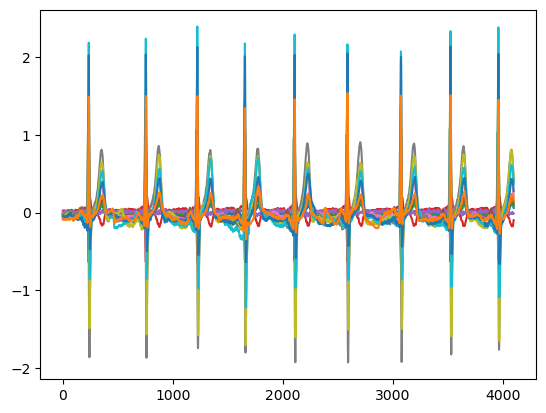

In [319]:
# read an ECG signal
n = 4
with h5py.File(f'../data/records/A{n:05d}.h5', 'r') as f:
    signal = f['ecg'][:, :4096]
    
print('The size of record: {}'.format(signal.shape))
# plot the signal
for i in range(12):
    plt.plot(signal[i])

Before being input to the model, each signal is rescaled to a range of approximately -1 to 1. 

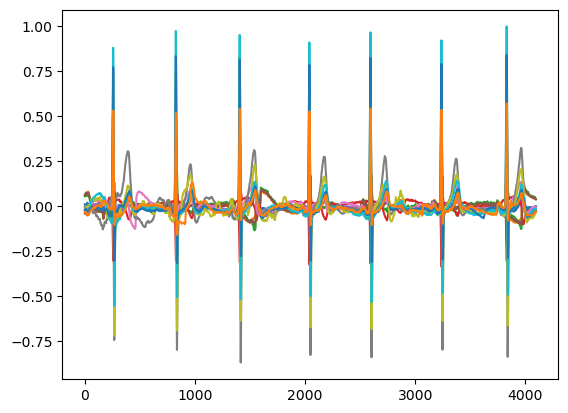

In [404]:
signal = normalize(signal)
for i in range(12):
    plt.plot(signal[i,:])

## Model Performance Evaluation